In [73]:
import os
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
!conda list | grep rdkit

rdkit                     2018.09.2.0      py36h865188c_1    rdkit


In [3]:
# !wget http://gdbtools.unibe.ch:8080/cdn/gdb11.tgz ## Need to open a VPN connection

In [4]:
smifile = '/mnt/c/Users/harshdeep.harshdeep/AppData/Local/Packages/CanonicalGroupLimited.UbuntuonWindows_79rhkp1fndgsc/LocalState/gdb11_size08.smi'
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])

In [5]:
data

,smiles,No,Int
0,CC(C)CC(C)(C)C,1,1
1,CC(N)CC(C)(C)C,2,1
2,CC(O)CC(C)(C)C,3,1
3,CC(F)CC(C)(C)C,4,1
4,CC(C)(C)CC(F)F,5,1
...,...,...,...
66701,C1C2C3C4CN(C14)C23,66702,1
66702,C1C2C3CN4C2C4C13,66703,1
66703,C1C2C3NC2C4C3N14,66704,1
66704,C1C2C3OC2C4C3N14,66705,1


## Convert SMILES into DEEPSmiles

In [5]:
import deepsmiles
converter = deepsmiles.Converter(rings=True, branches=True)
print(converter) # record the options used

Converter(rings=True, branches=True)


In [14]:
encoded = converter.encode("C1C2C3OC2C4C3N14")
print("Encoded: %s" % encoded)

decoded = converter.decode(encoded) ## For decoding the DeepSmiles into Smiles
print('Decoded: %s' % decoded)

Encoded: CCCOC4CC5N83
Decoded: C3C1C2OC1C4C2N34


In [8]:
data['smiles'] = data['smiles'].apply(lambda x: converter.encode(x))

In [15]:
data

,smiles,No,Int
0,CCC)CCC)C)C,1,1
1,CCN)CCC)C)C,2,1
2,CCO)CCC)C)C,3,1
3,CCF)CCC)C)C,4,1
4,CCC)C)CCF)F,5,1
...,...,...,...
66701,CCCCCNC74)C65,66702,1
66702,CCCCNC5C3C86,66703,1
66703,CCCNC4CC5N83,66704,1
66704,CCCOC4CC5N83,66705,1


### Making the training, testing dataset, convert it into one hot encoded vectors

In [16]:
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=0)
print(smiles_train.shape, smiles_test.shape)

(50029,) (16677,)


In [17]:
charset = set("".join(list(data.smiles))+"!E") # Get all the unique characters
char_to_int = dict((c,i) for i,c in enumerate(charset)) # Set unique indexes for each character
int_to_char = dict((i,c) for i,c in enumerate(charset)) # vice versa as above
embed = max([len(smile) for smile in data.smiles]) + 5 # Set max length which needs to be fed into the RNN  + 5 for some other
print(str(charset))
print(len(charset), embed)

{'C', '[', 'E', '=', 'n', 'N', 'c', '#', 'o', 'F', 'H', ']', '5', 'O', '8', '7', '3', '6', '!', '4', '-', ')', '+'}
23 26


### One hot encoding it

In [18]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [19]:
X_train, Y_train = vectorize(smiles_train.values)
X_test, Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])

CNCC3C#CCO


In [20]:
X_train[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

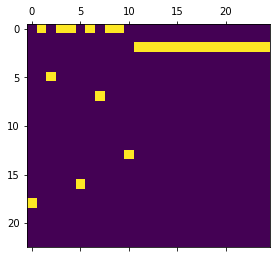

In [21]:
plt.matshow(X_train[0].T)

### Constructing the autoencoder

In [22]:
print(X_train.shape[1:]) ## Input to the autoencoder

(25, 23)


In [23]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

Using TensorFlow backend.


In [24]:
unroll = False
encoder_inputs = Input(shape=input_shape, name='encoder_input')
encoder = LSTM(lstm_dim, return_state=True, unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states) ## This will act as the state from the encoder

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape, name='decoder_input')
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 25, 23)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  22528       encoder_input[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]        

In [26]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
# So that learning rate can be adjusted while learning has been done
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

/home/harshdeep/anaconda3/envs/env_time/lib/python3.6/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [28]:
model.fit([X_train,X_train], Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test], Y_test])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 50029 samples, validate on 16677 samples
Epoch 1/200
50029/50029 [==============================] - 17s 332us/step - loss: 0.8608 - val_loss: 0.6609
Epoch 2/200
50029/50029 [==============================] - 17s 348us/step - loss: 0.6202 - val_loss: 0.5855
Epoch 3/200
50029/50029 [==============================] - 17s 343us/step - loss: 0.5520 - val_loss: 0.5146
Epoch 4/200
50029/50029 [==============================] - 18s 356us/step - loss: 0.4927 - val_loss: 0.4438
Epoch 5/200
50029/50029 [==============================] - 17s 344us/step - loss: 0.4144 - val_loss: 0.4124
Epoch 6/200
50029/50029 [==============================] - 20s 398us/step - loss: 0.3513 - val_loss: 0.3155
Epoch 7/200
50029/50029 [==============================] - 18s 367us/step - loss: 0.2972 - val_loss: 0.2972
Epoch 8/200
50029/50029 [==============================] - 18s 358us

50029/50029 [==============================] - 18s 362us/step - loss: 0.0019 - val_loss: 0.0026
Epoch 70/200
50029/50029 [==============================] - 18s 361us/step - loss: 0.0017 - val_loss: 0.0025
Epoch 71/200
50029/50029 [==============================] - 18s 357us/step - loss: 0.0016 - val_loss: 0.0027
Epoch 72/200
50029/50029 [==============================] - 18s 355us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 73/200
50029/50029 [==============================] - 18s 355us/step - loss: 0.0336 - val_loss: 0.0907
Epoch 74/200
50029/50029 [==============================] - 18s 358us/step - loss: 0.0122 - val_loss: 0.0042
Epoch 75/200
50029/50029 [==============================] - 18s 358us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 76/200
50029/50029 [==============================] - 18s 359us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 77/200
50029/50029 [==============================] - 18s 362us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 78/200
50029/50029 [======

50029/50029 [==============================] - 19s 380us/step - loss: 4.1607e-04 - val_loss: 8.3986e-04
Epoch 141/200
50029/50029 [==============================] - 19s 383us/step - loss: 3.2770e-04 - val_loss: 7.5420e-04
Epoch 142/200
50029/50029 [==============================] - 22s 442us/step - loss: 2.7918e-04 - val_loss: 6.8620e-04
Epoch 143/200
50029/50029 [==============================] - 24s 476us/step - loss: 2.4683e-04 - val_loss: 6.5104e-04
Epoch 144/200
50029/50029 [==============================] - 20s 400us/step - loss: 2.2738e-04 - val_loss: 6.0812e-04
Epoch 145/200
50029/50029 [==============================] - 19s 378us/step - loss: 2.0536e-04 - val_loss: 5.8948e-04
Epoch 146/200
50029/50029 [==============================] - 19s 387us/step - loss: 1.9082e-04 - val_loss: 5.7143e-04
Epoch 147/200
50029/50029 [==============================] - 18s 359us/step - loss: 1.7740e-04 - val_loss: 5.4733e-04

Epoch 00147: ReduceLROnPlateau reducing learning rate to 0.0006249999

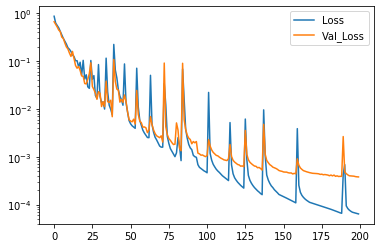

In [29]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [30]:
print()
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    print(pred, true)


CCCN=CNC)CEEEEEEEEEEEEEE CCCN=CNC)CEEEEEEEEEEEEEE
NCCCCN3N=C7EEEEEEEEEEEEE NCCCCN3N=C7EEEEEEEEEEEEE
NN=CC=CCO)=OEEEEEEEEEEEE NN=CC=CCO)=OEEEEEEEEEEEE
CCCCF)F))N3CEEEEEEEEEEEE CCCCF)F))N3CEEEEEEEEEEEE
FCC=O)CON=CEEEEEEEEEEEEE FCC=O)CON=CEEEEEEEEEEEEE
CCCCN)C=CCEEEEEEEEEEEEEE CCCCN)C=CCEEEEEEEEEEEEEE
CCCC)CF)CFEEEEEEEEEEEEEE CCCC)CF)CFEEEEEEEEEEEEEE
CCCCO)CC5=CEEEEEEEEEEEEE CCCCO)CC5=CEEEEEEEEEEEEE
Ocn[nH]nO)c5=OEEEEEEEEEE Ocn[nH]nO)c5=OEEEEEEEEEE
CCCOCCC3O6EEEEEEEEEEEEEE CCCOCCC3O6EEEEEEEEEEEEEE
Occoc=O)cn6EEEEEEEEEEEEE Occoc=O)cn6EEEEEEEEEEEEE
CCF)C=CCN)=NEEEEEEEEEEEE CCF)C=CCN)=NEEEEEEEEEEEE
CNCCNC))C=CEEEEEEEEEEEEE CNCCNC))C=CEEEEEEEEEEEEE
CCF)F)C#CC#NEEEEEEEEEEEE CCF)F)C#CC#NEEEEEEEEEEEE
OCCCCC5NC7EEEEEEEEEEEEEE OCCCCC5NC7EEEEEEEEEEEEEE
CCCCO4)CF)=CEEEEEEEEEEEE CCCCO4)CF)=CEEEEEEEEEEEE
COCC)CN)CFEEEEEEEEEEEEEE COCC)CN)CFEEEEEEEEEEEEEE
CC=O)cccc[nH]5EEEEEEEEEE CC=O)cccc[nH]5EEEEEEEEEE
FCF)=COCC#NEEEEEEEEEEEEE FCF)=COCC#NEEEEEEEEEEEEE
COC=C)CC)C=CEEEEEEEEEEEE COC=C)CC)C=CEEEEEEEEEEEE

In [31]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

In [32]:
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [33]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [34]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [35]:
#Transfer Weights from autoencoder model to the other model - which is the same as the previous one just with batch one
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

### Latent space exploration

In [36]:
x_latent = smiles_to_latent_model.predict(X_test)

[   10  7893 13046  9923 11086 14536 15269  8673  5013  4134]
31803       Oc1coc(=O)cn1
14010       Oc1ccoc(=O)n1
14013       Oc1cnoc(=N)n1
13971       Oc1ccoc(=O)c1
14490       Oc1cnoc(=N)c1
38552         Oc1cocnc1=N
41625        Oc1coc(O)c1O
33935    OCc1coc(=O)[nH]1
Name: smiles, dtype: object


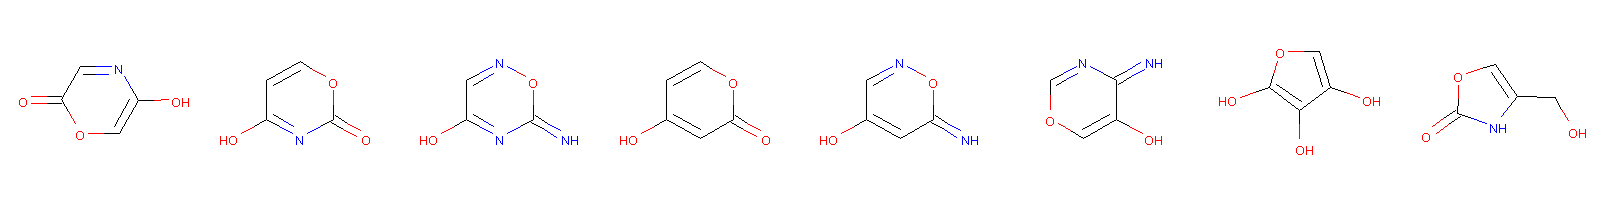

In [52]:
molno = 10
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
# print(smiles_test.iloc[sorti[0:8]])
test_results = smiles_test.iloc[sorti[0:8]].apply(lambda x: converter.decode(x))
print(test_results)
Draw.MolsToImage(test_results.apply(Chem.MolFromSmiles))

In [53]:
## Most different molecules in the molecule space
test_results = smiles_test.iloc[sorti[-8:]].apply(lambda x: converter.decode(x))
print(test_results)
# Draw.MolsToImage(test_results.apply(Chem.MolFromSmiles))

36065       NN(CC1CN1)C=N
4937     CC1(CC1)C(F)(F)F
25746       CC1(CCC=C)CC1
36090       NC(CN1CC1)C=C
25692        CC1(CCCF)CC1
66608      NC(C1CC1)C2CC2
36098       NC(CC1CC1)C#C
36027       CC(CC1CC1)C=O
Name: smiles, dtype: object


In [64]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,23))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,23))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return converter.decode(smiles)

In [66]:
#Interpolation test in latent_space
i = 0
j = 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
print('Latent 0 : {} and Latent 1: {}'.format(latent_to_smiles(latent0), latent_to_smiles(latent1)))
print('\n\n')

ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    # Using linear interpolation
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    # print(smiles)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print('NOT FOUND IN THE SMILES DATASET', smiles)
# Draw.MolsToGridImage(mols1, molsPerRow=1)

Latent 0 : CCCN=CN(C)C and Latent 1: NN=CC=CC(O)=O



NOT FOUND IN THE SMILES DATASET CCNC=CN(C)=O
NOT FOUND IN THE SMILES DATASET N1C=NC(C)N1(F)F
NOT FOUND IN THE SMILES DATASET N1C=NC(C)N1(F)F


In [67]:
logp = smiles_test.apply(lambda x: converter.decode(x)).apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.24040066 0.17729656] 0.41769722


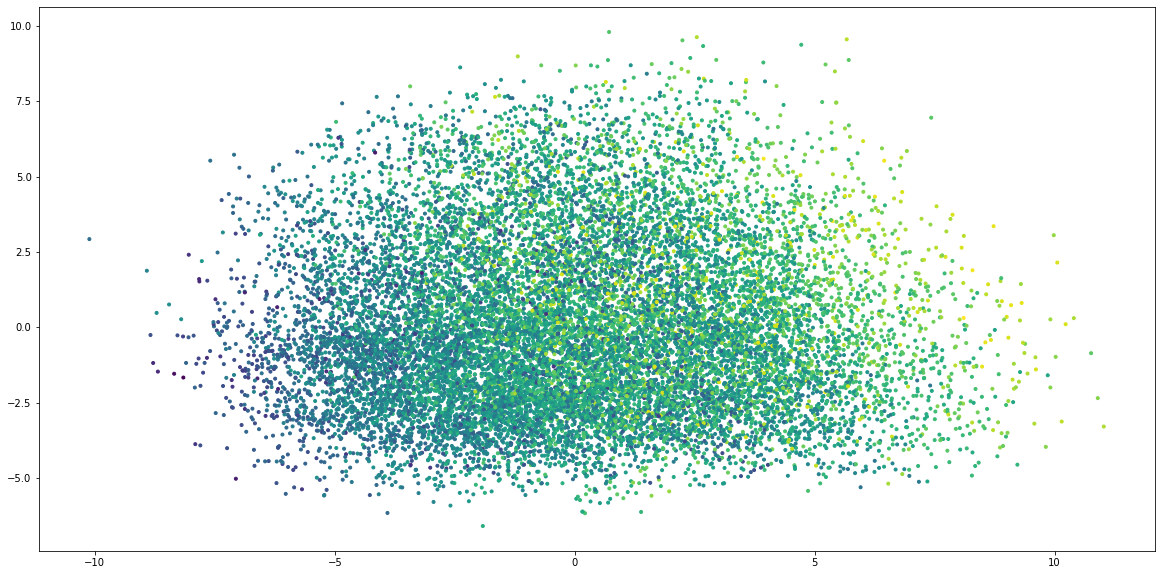

In [68]:
## More points pointing towards the center of the latent space which is a good practive
## Rather than without Deep Smiles where they are scattered all over the place
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure(figsize=(20,10))
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

In [69]:
# molmr = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
# plt.figure()
# plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [70]:
# Descriptors.MolLogP?

In [77]:
# Get 
wrong = 0
for i in tqdm_notebook(range(len(x_latent))):
    try:
        smiles = latent_to_smiles(x_latent[i:i+1])
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            print(smiles)
            wrong = wrong + 1
    except:
        print('DeepSmiles Error')
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

c1[nH]n2c3nnnc123
c[nH][nH]1c=NN=Nc1
O=C1CCCCO1O
C1C2NCCN13CC23
Nc[nH]1oc(C)c=N1
OC=CN=N(N)C#N
DeepSmiles Error
C=NN12CC(C1)CO2
CC1=NN=CN1=CF
CON=Cn1co[nH]c1
cc2cn1onnc1o2
N=co1[nH]cCc1N
OC1O2COC1CO2
CC12(NCC1)OCC=2

1.4 percent wrongly formatted smiles
